# MVP and HRP Portfolio Design for Oil & Gas Sector Stocks


<a id='1'></a>
## 1. Loading the Data and Python Libraries

<a id='1.1'></a>
### 1.1. Loading the Python Libraries

In [41]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

#Import Model Packages 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers


<a id='1.2'></a>
### 1.2. Loading the Data

In [42]:
# load dataset
dataset = read_csv('oil_and_gas.csv',index_col=0)

In [43]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [44]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
## 2. Exploratory Data Analysis

In [45]:
# shape
dataset.shape

(1482, 10)

In [46]:
# peek at data
set_option('display.width', 100)
dataset.head()

RELIANCE        ONGC  ATGL        BPCL         IOC        GAIL   HINDPETRO  \
date                                                                                       
01-01-2016  502.907929  161.666672   NaN  298.683319  108.312500  103.992241  189.744446   
04-01-2016  492.977081  158.699997   NaN  297.149994  106.612503  101.193802  190.322220   
05-01-2016  497.855835  161.233337   NaN  300.883331  110.662498  104.695366  190.366669   
06-01-2016  511.253815  158.366669   NaN  304.100006  112.712502  104.821930  195.922226   
07-01-2016  501.867798  151.066666   NaN  294.750000  110.387497  104.231300  190.811112   

                   IGL    PETRONET   GUJGASLTD  
date                                            
01-01-2016  105.389999  129.500000  125.739998  
04-01-2016  103.849998  124.800003  123.709999  
05-01-2016  111.290001  129.899994  131.020004  
06-01-2016  113.540001  134.100006  128.270004  
07-01-2016  112.050003  131.524994  127.239998

<a id='3'></a>
## 3. Data Pre-processing

<a id='3.1'></a>
### 3.1. Data Cleaning
We check for the NAs in the rows, either drop them or fill them with the mean of the column.

In [47]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())
dataset.shape

Null Values = True


(1482, 10)

Getting rid of the columns with more than 50% missing values.The threshold is increased so that an important stock in this sector, ATGL is included in the portfolios. 

In [48]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.5].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(1482, 10)

Given that there are null values drop the rown contianing the null values.

In [49]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')
dataset.head()

RELIANCE        ONGC  ATGL        BPCL         IOC        GAIL   HINDPETRO  \
date                                                                                       
01-01-2016  502.907929  161.666672   NaN  298.683319  108.312500  103.992241  189.744446   
04-01-2016  492.977081  158.699997   NaN  297.149994  106.612503  101.193802  190.322220   
05-01-2016  497.855835  161.233337   NaN  300.883331  110.662498  104.695366  190.366669   
06-01-2016  511.253815  158.366669   NaN  304.100006  112.712502  104.821930  195.922226   
07-01-2016  501.867798  151.066666   NaN  294.750000  110.387497  104.231300  190.811112   

                   IGL    PETRONET   GUJGASLTD  
date                                            
01-01-2016  105.389999  129.500000  125.739998  
04-01-2016  103.849998  124.800003  123.709999  
05-01-2016  111.290001  129.899994  131.020004  
06-01-2016  113.540001  134.100006  128.270004  
07-01-2016  112.050003  131.524994  127.239998

<a id='3.2'></a>
### 3.2. Training and Test Dataset Preparation

For the purpose of clustering, we will be using annual return figures. Let us prepare the dataset for training and testing, by separating 83.30% of the records for training the models and remaining records for testing. These figures have been chosen in such a way that the records of the year 2021 go into the test dataset while other records remain in the training dataset.

In [50]:
X= dataset.copy('deep')
row= len(X)
train_len = int(row*.8330)

In [51]:
X_train = X.head(train_len)

In [52]:
X_train

RELIANCE        ONGC        ATGL        BPCL         IOC        GAIL   HINDPETRO  \
date                                                                                              
01-01-2016   502.907929  161.666672         NaN  298.683319  108.312500  103.992241  189.744446   
04-01-2016   492.977081  158.699997         NaN  297.149994  106.612503  101.193802  190.322220   
05-01-2016   497.855835  161.233337         NaN  300.883331  110.662498  104.695366  190.366669   
06-01-2016   511.253815  158.366669         NaN  304.100006  112.712502  104.821930  195.922226   
07-01-2016   501.867798  151.066666         NaN  294.750000  110.387497  104.231300  190.811112   
...                 ...         ...         ...         ...         ...         ...         ...   
24-12-2020  1994.150024   93.150002  368.549988  377.549988   90.250000  120.150002  213.649994   
28-12-2020  2003.300049   93.800003  368.899994  382.750000   91.699997  122.650002  215.199997   
29-12-2020  1990.050049   93.150002  374.600006  381.500000   91.199997  123.750000  215.399994   
30-12-2020  1995.500000   93.250000  380.399994  382.850006   90.900002  123.099998  216.449997   
31-12-2020  1985.300049   93.050003  375.600006  381.100006   90.949997  123.250000  217.899994   

                   IGL    PETRONET   GUJGASLTD  
date                                            
01-01-2016  105.389999  129.500000  125.739998  
04-01-2016  103.849998  124.800003  123.709999  
05-01-2016  111.290001  129.899994  131.020004  
06-01-2016  113.540001  134.100006  128.270004  
07-01-2016  112.050003  131.524994  127.239998  
...                ...         ...         ...  
24-12-2020  489.149994  246.100006  375.700012  
28-12-2020  490.049988  251.149994  375.100006  
29-12-2020  511.100006  247.000000  380.750000  
30-12-2020  505.549988  246.500000  382.200012  
31-12-2020  502.350006  247.600006  376.399994  

[1234 rows x 10 columns]

In [53]:
X_test = X.tail(row-train_len)

In [54]:
#Calculate percentage return 
returns = X_train.pct_change().dropna()
returns_test=X_test.pct_change().dropna()

The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms.

<a id='4'></a>
## 4. Evaluate the Models

<a id='4.1'></a>
### 4.1. Building Dendrogram for the HRP Model

The first step is to look for clusters of correlated stcoks using the agglomerate hierarchical clustering technique. The hierarchy class
has a dendrogram method which takes the value returned by the linkage method of
the same class.

Linkage does the actual clustering in one line of code, and returns a list of the clusters joined in the format: Z=[stock_1, stock_2, distance, sample_count]

#### Correlation Computation

In [55]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [56]:
#Calulate linkage
dist = correlDist(returns.corr())
link = linkage(dist, 'ward')
link[0]

array([3.        , 6.        , 0.47815538, 2.        ])

Computation of linkages is followed by the visualization of the clusters through a dendrogram, which displays a cluster tree.
The leaves are the individual stocks and the root represents the final single cluster. The “distance” between each cluster is shown along the y-axis, and thus the longer the branches indicate less correlated clusters of stcoks.

In [57]:
#Plot Dendogram
plt.figure(figsize=(20, 7))
#plt.title("Dendrograms")
dendrogram(link,labels = X.columns, leaf_font_size=14)
plt.show()

<a id='4.2'></a>
### 4.2 Steps involved in the HRP Model Design 

#### Quasi-Diagonalization and Weights Computation for HRP


Quasi-diagonalization is a matrix seriation process used in hierarchical clustering. The process involves reorganizing the covariance matrix of returns in such a way that stocks with similar returns are placed together. This matrix diagonalization allows us to distribute weights optimally following an inverse-variance allocation. For more details refer to Chapter 4 of the book.

In [58]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

#### Recursive Bisection

This step distributes the weights through recursive bisection based on the cluster covariance.

In [59]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar



def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

#### Comparison of HRP with MVP

So, in this step, python functions are defined for comparing the following two portfolio design approaches.

    1. MVP - Markowitz’s Minimum-Variance Portfolio
    2. HRP - Hierarchial Risk Parity

In [60]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #plt.figure(figsize=(20, 10))
    #dn = sch.dendrogram(link, labels=cov.index.values)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

#### Computation of the Weight Allocation for the Portfolios

In [61]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    portfolios = pd.DataFrame([mvp, hrp], index=['MVP', 'HRP']).T
    #portfolios = pd.DataFrame([ivp, hrp], index=['IVP', 'HRP']).T
    return portfolios

In [62]:
portfolios = get_all_portfolios(returns)
print(portfolios)

                MVP       HRP
RELIANCE   0.139853  0.110001
ONGC       0.005747  0.047863
ATGL       0.019074  0.067857
BPCL       0.002955  0.063280
IOC        0.166755  0.106743
GAIL       0.035430  0.057686
HINDPETRO  0.004582  0.072036
IGL        0.163450  0.158775
PETRONET   0.274047  0.152529
GUJGASLTD  0.188108  0.163229


In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,20))
ax1.pie(portfolios.iloc[:,0], labels= portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax1.set_title('MVP',fontsize = 30)
ax2.pie(portfolios.iloc[:,1], labels=portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax2.set_title('HRP',fontsize = 30)
#portfolios.plot.pie(subplots=True, figsize=(20, 10),legend = False);

Text(0.5, 1.0, 'HRP')

In [64]:
# MVP - Markowitz’s Minimum-Variance Portfolio Weights
portfolios.iloc[:,0]

RELIANCE     0.139853
ONGC         0.005747
ATGL         0.019074
BPCL         0.002955
IOC          0.166755
GAIL         0.035430
HINDPETRO    0.004582
IGL          0.163450
PETRONET     0.274047
GUJGASLTD    0.188108
Name: MVP, dtype: float64

In [65]:
# HRP - Hierarchial Risk Parity Portfolio Weights
portfolios.iloc[:,1]

RELIANCE     0.110001
ONGC         0.047863
ATGL         0.067857
BPCL         0.063280
IOC          0.106743
GAIL         0.057686
HINDPETRO    0.072036
IGL          0.158775
PETRONET     0.152529
GUJGASLTD    0.163229
Name: HRP, dtype: float64

<a id='5'></a>
## 5. Performance Evaluation of the Portfolios 

### 5.1 Cumulative Returns - Training and Test Data 

In [66]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['MVP', 'HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['MVP', 'HRP'], index = returns_test.index)

<AxesSubplot:xlabel='date', ylabel='Return'>

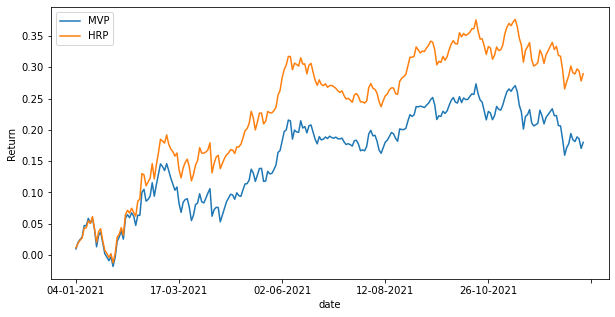

In [67]:
Insample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")
OutOfSample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")

In [68]:
ret_insample=Insample_Result.mean() * 252
ret_insample

MVP    0.234466
HRP    0.256960
dtype: float64

In [69]:
ret_out_of_sample = OutOfSample_Result.mean() * 252
ret_out_of_sample

MVP    0.18365
HRP    0.29557
dtype: float64

###  5.2 Sharpe Ratio and Annual Volatility - Training and Test Data

In [70]:
#In_sample Results
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

stdev  sharp_ratio
MVP  0.229778     1.020405
HRP  0.243277     1.056246

In [71]:
#Outof_sample Results
stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

stdev_oos  sharp_ratio_oos
MVP   0.183589         1.000333
HRP   0.190558         1.551079